In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import src.kgbench as kg
import fire, sys
import math

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# #
#from torch_geometric.utils import to_networkx
# import networkx as nx

from src.rgcn_explainer_utils import *
from IPython.core.interactiveshell import InteractiveShell
from rgcn_model import RGCN



In [7]:
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [11]:
import kgbench as kg
from src.rgcn_explainer_utils import *

data = kg.load('dmg777k', torch=True, final=False)
data = prunee(data, 2)
get_relations(data)
relations = [data.i2rel[i][0] for i in range(len(data.i2rel))]

loaded data dmg777k (86.54s).


In [14]:
data.num_classes

5

In [10]:
pred = torch.load('chk/am_chk/models/prediction_am_prune_True')
pred.shape

torch.Size([198, 11])

In [15]:
for i in range(len(data.i2rel)):
    print(i, data.i2rel[i][0])

0 asWKT-RD
1 city
2 codeNationalMonument
3 location
4 name
5 neighbourhood
6 thumbnail
7 created
8 creator
9 description
10 isPartOf
11 spatial
12 dateCreated
13 roleName
14 alternateName
15 countryCode
16 featureClass
17 featureCode
18 locationMap
19 name
20 nearbyFeatures
21 officialName
22 parentADM1
23 parentADM2
24 parentCountry
25 parentFeature
26 population
27 wikipediaArticle
28 asWKT
29 hasGeometry
30 sfWithin
31 type
32 isDefinedBy
33 label
34 seeAlso
35 sameAs
36 alt
37 hasStreetAddress
38 postal-code
39 street-address
40 depiction
41 depicts
42 name
43 bouwjaar
44 complexnummer
45 fotograaf
46 graveur
47 huisnummer
48 huisnummerCompleet
49 huisnummerToevoeging
50 internComplexNummers
51 isFree
52 locator
53 ontwerper
54 reprofotograaf
55 rnaSubject
56 schilder
57 techniek
58 tekenaar
59 regiocode


In [67]:
def find_threshold(sparse_tensor, num_exp):
    ''' Find the threshold value for the sparse tensor'''
    # sparse_tensor = torch.sparse_coo_tensor(
    #     sparse_tensor.coalesce().indices()%data.num_entities, sparse_tensor.coalesce().values(), size=sparse_tensor.size()
    # )
    numbers = sparse_tensor.coalesce().values()
    sorted_numbers = sorted(numbers, reverse=True)
    count = 0
    threshold = None
    
    for num in sorted_numbers:
        if count == num_exp:
            break
        threshold = num
        count += 1
    
    return threshold


def threshold_mask(h,v ,data, num_exp, equal=True):
    ''' Apply a threshold mask to the adjacency matrix'''
    t_v, t_h =     find_threshold(v, num_exp), find_threshold(h, num_exp)
    #v, h = convert_back(v, data), convert_back(h, data)
    v_thresh, h_thresh = convert_binary(v,t_v,equal), convert_binary(h,t_h,equal)
    return h_thresh,v_thresh,t_h,t_v

In [96]:
def convert_binary_num(sparse_tensor, threshold_num ,equal=True):
    ''' Converts a sparse tensor to a binary sparse tensor based on a threshold'''
    # convert values to either 0 or 1 based on a threshold of 0.5
    top_values, top_indices = torch.topk(tensor, k=n)
    mask = sparse_tensor._values() >= threshold
    if equal==False:
        mask = sparse_tensor._values() > threshold

    converted_values = torch.zeros_like(sparse_tensor._values())
    converted_values[mask] = 1
    #print("Number of non zero values: ", converted_values.nonzero().size(0))

    # create a new sparse tensor with the converted values
    converted_sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), converted_values, size=sparse_tensor.size())

    return converted_sparse_tensor

tensor(indices=tensor([[ 23451,  23451,  23451,  ..., 329925, 329926, 329927],
                       [  5678,   5743,   5746,  ...,   5230,   5230,   5230]]),
       values=tensor([1., 1., 1.,  ..., 0., 0., 0.]),
       size=(753935, 8285), nnz=1311, layout=torch.sparse_coo)

In [108]:
import torch

def get_n_highest_sparse(tensor, n):
    ''' Get the n highest elements of a sparse tensor'''
    # Get the number of non-zero elements in the sparse tensor
    nnz = tensor._nnz()

    # Check if n is greater than nnz, and handle it accordingly
    if n >= nnz:
        # If n is greater than or equal to nnz, select all non-zero elements
        selected_indices = tensor._indices()
        selected_values = tensor._values()
    else:
        # Get the indices and values of the top n highest elements
        values, indices = torch.topk(tensor._values(), n)

        # Get the corresponding row and column indices from the original tensor
        row_indices = tensor._indices()[0][indices]
        col_indices = tensor._indices()[1][indices]

        # Combine the row and column indices to form the selected indices
        selected_indices = torch.stack((row_indices, col_indices))

        # Get the corresponding values from the original tensor
        selected_values = tensor._values()[indices]
        sel_tensor = torch.sparse_coo_tensor(selected_indices, selected_values, size=tensor.size())
        sel_tensor = convert_binary(sel_tensor, 0, equal=False)
    return sel_tensor

# Example sparse tensor
indices = torch.tensor([[0, 1, 1],
                        [1, 0, 1]])

values = torch.tensor([2, 3, 4], dtype=torch.float32)

# Create the sparse tensor
sparse_tensor = v#torch.sparse_coo_tensor(indices, values, size=(2, 2))

n = 15
get_n_highest_sparse(sparse_tensor, n)



tensor(indices=tensor([[23567, 23551, 23458, 23567, 23551, 23458, 23551, 23451,
                        23567, 23458, 23567, 23451, 23451, 23451, 23551],
                       [ 5678,  5745,  6610,  6683,  5743,  5678,  5746,  5746,
                         6404,  6611,  6685,  5678,  5743,  6404,  5678]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1.]),
       size=(753935, 8285), nnz=15, layout=torch.sparse_coo)

In [110]:
import torch
import random

def get_n_highest_sparse_with_specified(tensor, n, specified_value, specified_number):
    # Convert the sparse tensor to a dense tensor for indexing
    dense_tensor = tensor.to_dense()

    # Get the number of non-zero elements in the sparse tensor
    nnz = tensor._nnz()

    # Check if n is greater than nnz, and handle it accordingly
    if n >= nnz:
        # If n is greater than or equal to nnz, select all non-zero elements
        selected_indices = tensor._indices()
        selected_values = tensor._values()
    else:
        # Get the indices and values of the top n highest elements
        values, indices = torch.topk(dense_tensor, n)

        # Convert the indices to a sparse tensor
        selected_indices = indices.nonzero().t()

        # Get the corresponding values from the original tensor
        selected_values = tensor[selected_indices[0], selected_indices[1]]

        # Create a mask to identify indices with values equal to the specified value
        specified_mask = selected_indices[1] == specified_value
        specified_indices = selected_indices[:, specified_mask]

        # Check if there is at least the specified number of indices with the specified value
        if specified_indices.size(1) < specified_number:
            # If not, randomly replace indices with the specified value until we have the specified number
            replace_indices = torch.randint(0, nnz, (specified_number - specified_indices.size(1),))
            selected_indices[:, specified_mask] = tensor._indices()[:, replace_indices]

        # Get the corresponding values from the original tensor
        selected_values = tensor[selected_indices[0], selected_indices[1]]

    # Convert the selected indices and values back to a sparse tensor
    selected_sparse_tensor = torch.sparse_coo_tensor(selected_indices, selected_values, size=tensor.size())

    return selected_values, selected_sparse_tensor

# Your sparse tensor
indices = torch.tensor([[23567, 23551, 23458, 23567, 23551, 23458, 23551, 23451,
                        23567, 23458, 23567, 23451, 23451, 23451, 23551],
                       [ 5678,  5745,  6610,  6683,  5743,  5678,  5746,  5746,
                         6404,  6611,  6685,  5678,  5743,  6404,  5678]])

values = torch.tensor([0.2, 0.3, 0.2, 0.2, 0.5, 0.4, 0.2, 0.3, 0.2, 0.2, 0.5, 0.4, 0.2, 0.5, 0.5], dtype=torch.float32)

# Create the sparse tensor
sparse_tensor = torch.sparse_coo_tensor(indices, values, size=(753935, 8285))

n = 5
specified_value = 5678
specified_number = 1
selected_values, selected_sparse_tensor = get_n_highest_sparse_with_specified(sparse_tensor, n, specified_value, specified_number)
print("Selected Values:", selected_values)
print("Selected Indices:", selected_sparse_tensor._indices())


In [97]:
h = torch.load('chk/aifb_chk/exp/init_const_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_1_type_1_killMFR_False/masked_adj/masked_hor5678')
v = torch.load('chk/aifb_chk/exp/init_const_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_1_type_1_killMFR_False/masked_adj/masked_ver5678')
# h,v,t_h,t_v = threshold_mask(h,v,data, 25, equal=True)
# torch.mean(h.coalesce().values())
# v.coalesce().values().count_nonzero()
# h.coalesce().values().count_nonzero()

In [98]:
v_thresh = v.coalesce

tensor(indices=tensor([[ 23451,  23451,  23451,  ..., 329925, 329926, 329927],
                       [  5678,   5743,   5746,  ...,   5230,   5230,   5230]]),
       values=tensor([0.9928, 0.9928, 0.9928,  ..., 0.9928, 0.9928, 0.9928]),
       size=(753935, 8285), nnz=1311, layout=torch.sparse_coo)

In [13]:
dict_classes = d_classes(data)
dict_classes
min_length = min(len(value) for value in dict_classes.values())
num_samples_per_class = 30 if min_length > 30 else min_length 
total_elements = sum(len(value) for value in dict_classes.values())
print(total_elements)

{'BIK': 0, 'CoM': 1, 'Forschungsgebiete': 2, 'Forschungsgruppen': 3, 'Kooperationen': 4, 'Personen': 5, 'Projekte': 6, 'Publications': 7, 'Publikationen': 8, 'WBS': 9, 'eOrganisation': 10, 'fbe': 11, 'kangal': 12, 'mitarbeiter': 13, 'optrek': 14, 'padlr': 15, 'projects': 16, 'prost': 17, 'uli': 18, 'wiki': 19, 'wim': 20, 'ze': 21}
35


In [61]:
import numpy as np
from scipy.stats import chi2_contingency



# Get the set of common relation names
common_relations = set(full_graph_relations.keys()).intersection(explanation_subgraph_relations.keys())

# Extract the counts for common relations
full_graph_counts = np.array([full_graph_relations[relation] for relation in common_relations])
explanation_counts = np.array([explanation_subgraph_relations[relation] for relation in common_relations])

# Perform chi-squared test
observed = np.array([full_graph_counts, explanation_counts])
chi2, p, _, _ = chi2_contingency(observed)

print("Chi-Squared Statistic:", chi2)
print("P-value:", p)



Chi-Squared Statistic: 24.588578445305824
P-value: 0.00016727053987577496


In [64]:
df = pd.read_csv('chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/Relation_Importance/Relations_Important_sample_threshold.csv')
df[relations]

,abstract,address,author,booktitle,carriedOutBy,carriesOut,chapter,dealtWithIn,edition,editor,...,volume,worksAtProject,year,type,type,range,subClassOf,allValuesFrom,inverseOf,onProperty
0,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


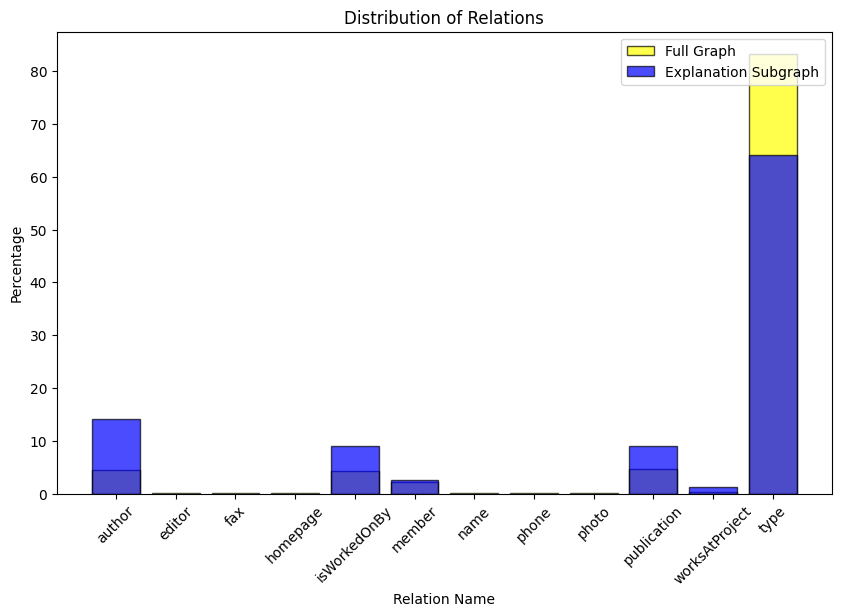

In [45]:
full_graph_df = pd.DataFrame(list(full_graph_relations.items()), columns=['Relation Name', 'Count'])
explanation_df = pd.DataFrame(list(explanation_subgraph_relations.items()), columns=['Relation Name', 'Count'])

# Calculate the total counts for both full graph and explanation subgraph
total_full_graph = full_graph_df['Count'].sum()
total_explanation = explanation_df['Count'].sum()

# Calculate the percentages for each relation in both full graph and explanation subgraph
full_graph_df['Percentage'] = full_graph_df['Count'] / total_full_graph * 100
explanation_df['Percentage'] = explanation_df['Count'] / total_explanation * 100

# Create the bar plot
plt.figure(figsize=(10, 6))

# Plot the full graph data with increased transparency (alpha = 0.7) and blue color
plt.bar(full_graph_df['Relation Name'], full_graph_df['Percentage'], alpha=0.7, color='yellow', edgecolor='black', label='Full Graph')

# Plot the explanation subgraph data with increased transparency (alpha = 0.7) and green color
plt.bar(explanation_df['Relation Name'], explanation_df['Percentage'], alpha=0.7, color='blue', edgecolor='black', label='Explanation Subgraph')

plt.xlabel('Relation Name')
plt.ylabel('Percentage')
plt.title('Distribution of Relations')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

In [66]:
import random
random.seed(42)
sampled_data = []
for key in dict_classes:
    sampled_data.extend(random.sample(dict_classes[key], 4))
sampled_data

[5783,
 5724,
 5678,
 5702,
 5905,
 5731,
 5808,
 5785,
 5861,
 5755,
 5797,
 5831,
 5857,
 5854,
 5798,
 5753]

In [5]:

v = torch.load(f'chk/mutag_chk/exp/init_overall_frequency_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_-1_type_-1_killtype_True_break_no/masked_adj/masked_ver6594')
h = torch.load(f'chk/mutag_chk/exp/init_overall_frequency_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_-1_type_-1_killtype_True_break_no/masked_adj/masked_hor6594')
h_t = find_threshold(h,10)
v_t = find_threshold(v,10)
print(h_t, v_t)
h,v,_,_=threshold_mask(h,v,data,10)
v.coalesce().values().count_nonzero()

tensor(0.5272) tensor(0.5272)


tensor(25)

In [23]:
name = 'aifb'
data = kg.load(name, torch=True, final=True)
data = prunee(data, 2)
model = torch.load(f'chk/{name}_chk/models/model_{name}_prune_True')
node_idx = 5757
init = 'relative_frequency'
'chk/aifb_chk/exp/init_overall_frequency_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_-1_type_-1_killtype_True_break_no/masked_adj'
#'chk/aifb_chk/exp/init_relative_frequency_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_-1_type_-1_killtype_True_break_no'
exp = f'init_{init}_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_-1_type_-1_killtype_True_break_no'
v = torch.load(f'chk/{name}_chk/exp/{exp}/masked_adj/masked_ver{node_idx}')
h = torch.load(f'chk/{name}_chk/exp/{exp}/masked_adj/masked_hor{node_idx}')
masked_ver = v
masked_hor = h
h_threshold, v_threshold,t_h, t_v = threshold_mask(masked_hor, masked_ver, data, 10)
res_threshold = nn.Softmax(dim=0)(model.forward2(h_threshold, v_threshold)[node_idx, :])

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/RGCN_stuff/src/kgbench.py:247: UserWarning: The validation data is not added to the training data. For AIFB, MUTAG, BGS and AM, the correct evaluation is to combine train and validation for the final evaluation run.Set include_val to True when loading the data.
  warnings.warn('The validation data is not added to the training data. For AIFB, MUTAG, BGS and AM, '


loaded data aifb (0.2145s).


In [4]:

i = 0
while res_threshold.argmax() != 0:
    h_threshold, v_threshold,t_h, t_v = threshold_mask(masked_hor, masked_ver, data, 1+i)
    i+=1
    res_threshold = nn.Softmax(dim=0)(model.forward2(h_threshold, v_threshold)[node_idx, :])
print(res_threshold)
print(1+i)
print(v_threshold.coalesce().values().count_nonzero())

tensor([0.8069, 0.0444, 0.1456, 0.0031], grad_fn=<SoftmaxBackward0>)
69
tensor(75)


In [25]:
i = 0
while res_threshold.argmax() != 2:
    h_threshold, v_threshold,t_h, t_v = threshold_mask(masked_hor, masked_ver, data, 1+i)
    i+=1
    res_threshold = nn.Softmax(dim=0)(model.forward2(h_threshold, v_threshold)[node_idx, :])
    if i== masked_hor.shape[0]:
        break


print(res_threshold)
print(1+i)
print(v_threshold.coalesce().values().count_nonzero(),masked_ver.coalesce().values().count_nonzero() )
res = nn.Softmax(dim=0)(model.forward2(convert_binary(masked_hor,0.5), convert_binary(masked_ver,0.5))[node_idx, :])
print(res)

tensor([0.0094, 0.0133, 0.9756, 0.0017], grad_fn=<SoftmaxBackward0>)
1
tensor(79) tensor(87)
tensor([0.2189, 0.2325, 0.4891, 0.0596], grad_fn=<SoftmaxBackward0>)


In [ ]:
def scores(res_full, res_expl,res1_m,label,masked_ver, config):
    ''' res_expl: res_binary , res_threshold'''
    fidelity_minus = float(1 - (res_full[int(label)] - res_expl[int(label)]))
    fidelity_plus = float((res_full[int(label)] - res1_m[int(label)]))
    print(fidelity_minus, fidelity_plus)
    explanation_lenght = len(masked_ver.coalesce().values()[masked_ver.coalesce().values()>config['threshold'] ])
    sparsity = float(1 - explanation_lenght/len(masked_ver.coalesce().values()))

    if sparsity == 1:
        sparsity_loss = 0
    if sparsity == 0:
        sparsity_loss = - 1
    else:
        sparsity_loss = sparsity
    score = fidelity_minus + fidelity_plus + sparsity_loss
    return fidelity_minus, fidelity_plus, sparsity, score

In [23]:
masked_ver = v
masked_hor = h
h_threshold, v_threshold,t_h, t_v = threshold_mask(masked_hor, masked_ver, data, 59)
res_threshold = nn.Softmax(dim=0)(model.forward2(h_threshold, v_threshold)[node_idx, :])
res_threshold

tensor([0.3945, 0.6055], grad_fn=<SoftmaxBackward0>)

In [27]:
import torch

# Create a sparse tensor with non-zero values and indices
indices = torch.tensor([[0, 1, 1], [1, 0, 1]])
values = torch.tensor([2, 3, 4])
size = (10, 2)
sparse_tensor = torch.sparse.FloatTensor(indices, values, size)

print("Original Sparse Tensor:")
print(sparse_tensor)

# Set all values to zero
sparse_tensor._values().zero_()

print("Sparse Tensor with All Values Set to 0:")
print(sparse_tensor)


Original Sparse Tensor:
tensor(indices=tensor([[0, 1, 1],
                       [1, 0, 1]]),
       values=tensor([2, 3, 4]),
       size=(10, 2), nnz=3, layout=torch.sparse_coo)
Sparse Tensor with All Values Set to 0:
tensor(indices=tensor([[0, 1, 1],
                       [1, 0, 1]]),
       values=tensor([0, 0, 0]),
       size=(10, 2), nnz=3, layout=torch.sparse_coo)


In [11]:
name = 'aifb'

data = kg.load(name, torch=True) 
print(data.triples.shape[0])
node_idx = 5678

# else:
#     data = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/data/IMDB/finals/{name}.pt')

data = prunee(data, 2)
print(data.triples.shape[0])
data.triples = torch.Tensor(data.triples).to(int)#data.triples.clone().detach()
data.withheld = torch.Tensor(data.withheld).to(int)#data.withheld.clone().detach()
data.training = torch.Tensor(data.training).to(int)#data.training.clone().detach()
#
get_relations(data)
d_classes(data)
dict_classes = {key.item(): data.withheld[:, 0][data.withheld[:, 1] == key].tolist() for key in torch.unique(data.withheld[:, 1])}
if name != 'aifb':
    node_idx = dict_classes[0][0]


from src.rgcn_explainer_utils import *
# v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_ver{node_idx}')
# h = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_hor{node_idx}')
model = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/model_{name}_prune_True')

# h = select_entity(h, 5230)
# v = select_entity(v, 5230)

v = torch.load(f'chk/aifb_chk/old_all/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_init_normal_break_wrong_pred_exp_/masked_adj/masked_ver{node_idx}')
h = torch.load(f'chk/aifb_chk/old_all/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_init_normal_break_wrong_pred_exp_/masked_adj/masked_hor{node_idx}')

# v = torch.sparse_coo_tensor(v.coalesce().indices(), torch.sigmoid(v.coalesce().values()), v.size(), requires_grad=True)
# h = torch.sparse_coo_tensor(h.coalesce().indices(), torch.sigmoid(h.coalesce().values()), h.size(), requires_grad=True)
out = model.forward2(h,v)

res = nn.Softmax(dim=0)(out[node_idx])
print('ypred explain', res)
# print(v.coalesce().values()[v.coalesce().values()>0.5])
# print(h.coalesce().values())

v_bin,h_bin = convert_binary(v, 0.5), convert_binary(h,0.5)
print('v binary:',v_bin, torch.count_nonzero(v_bin.coalesce().values()))
res = nn.Softmax(dim=0)(model.forward2(h_bin,v_bin)[node_idx, :])
print('ypred explain binary', res)

if node_idx in data.withheld[:,0]:
    print('ypred true', data.withheld[data.withheld[:,0]==node_idx,1])
    

model.eval()
hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
y_full = model.forward2(hor_graph, ver_graph)
node_pred_full = y_full[node_idx, :]
res_full = nn.Softmax(dim=0)(node_pred_full)
print('ypred full', res_full)

v,h = sub(v, 0.5), sub(h,0.5)
m = match_to_triples(v,h,data, node_idx)
Counter(m[:,1].tolist())

loaded data aifb (0.2276s).
29043
26666
ypred explain tensor([0.4507, 0.1969, 0.2936, 0.0587], grad_fn=<SoftmaxBackward0>)
v binary: tensor(indices=tensor([[ 23451,  23451,  23451,  ..., 329925, 329926, 329927],
                       [  5678,   5743,   5746,  ...,   5230,   5230,   5230]]),
       values=tensor([1., 1., 1.,  ..., 0., 0., 0.]),
       size=(753935, 8285), nnz=1311, layout=torch.sparse_coo) tensor(119)
ypred explain binary tensor([0.3810, 0.2180, 0.3542, 0.0468], grad_fn=<SoftmaxBackward0>)
ypred true tensor([0])
ypred full tensor([9.8647e-01, 5.4700e-04, 1.2982e-02, 1.1929e-06],
       grad_fn=<SoftmaxBackward0>)


Counter({2: 27, 10: 1, 15: 1, 18: 35, 21: 21, 27: 1, 30: 30, 36: 3, 0: 101})

In [12]:
node_idx = 5678
init = 'normal'
v = torch.load(f'chk/aifb_chk/old_all/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_init_normal_break_wrong_pred_exp_/masked_adj/masked_ver{node_idx}')
h = torch.load(f'chk/aifb_chk/old_all/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_init_normal_break_wrong_pred_exp_/masked_adj/masked_hor{node_idx}')
#v_bin,h_bin = convert_binary(v, 0.5), convert_binary(h,0.5)

In [14]:
def random_explanation_baseline(sparse_tensor):
    ''' Create a random explanation baseline for a given sparse tensor'''
    # Retrieve the indices of non-zero elements
    # explanation_lenght = len(sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values()>config['threshold'] ])
    explanation_lenght = len(sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values()> 0.5 ])
    indices = sparse_tensor._indices()

    # Get the total number of non-zero elements
    num_nonzero = indices.size(1)

    # Specify the number of random indices you want to select
    n = explanation_lenght

    # Generate 'n' random indices within the range of non-zero indices
    random_indices = torch.randperm(num_nonzero)[:n]

    # Create a new sparse tensor with the same shape as the original tensor but with all values set to 0
    new_sparse_tensor = torch.sparse.FloatTensor(indices, torch.zeros(num_nonzero), size=sparse_tensor.size())

    # Assign 1 to the randomly selected indices in the new sparse tensor
    new_sparse_tensor._values()[random_indices] = 1

    # Print the new sparse tensor
    return new_sparse_tensor

h_random, v_random = random_explanation_baseline(h), random_explanation_baseline(v)
counter = important_relation(h_random, v_random, data,node_idx, 0.5)
print('Important relations', counter)
res_random = nn.Softmax(dim=0)(model.forward2(h_random, v_random)[node_idx, :])
print(res_random)

Important relations {'author': 7, 'homepage': 1, 'isWorkedOnBy': 5, 'member': 2, 'publication': 4, 'type': 100}
tensor([0.2483, 0.2657, 0.2633, 0.2227], grad_fn=<SoftmaxBackward0>)


In [41]:
import kgbench as kg
from src.rgcn_explainer_utils import *

data = kg.load('aifb', torch=True, final=False)
data = prunee(data, 2)
get_relations(data)
relations = [data.i2rel[i][0] for i in range(len(data.i2rel))]
d = d_classes(data)
node_idx = d[list(d.keys())[0]][0] 

loaded data aifb (0.3375s).


In [24]:
#but I want to get the most frequent relations for a given node (2 hops)

def most_frequent_relations(data, node_idx, n_hops):
    ''' Most frequent relations for a given node (2 hops)'''
    hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
    edge_index_h, edge_index_v = hor_graph.coalesce().indices(), ver_graph.coalesce().indices()

    sub_edges_h, neighbors_h, sub_edges_tensor_h  = find_n_hop_neighbors(edge_index_h, n=n_hops, node=node_idx)
    sub_edges_v, neighbors_v, sub_edges_tensor_v  = find_n_hop_neighbors(edge_index_v, n=n_hops, node=node_idx)
    sub_triples = match_to_triples(sub_edges_tensor_v, sub_edges_tensor_h,data, sparse=False)
    sub_h, sub_v = hor_ver_graph(sub_triples, data.num_entities, data.num_relations)
    m = match_to_triples(sub_v, sub_h,data, node_idx)
    freq = Counter(m[:,1].tolist())
    sorted_freq = {data.i2r[k]: v for k, v in sorted(freq.items(), key=lambda item: item[1], reverse=True) if k!=0}

    most_freq_rel = list(sorted_freq.keys())[0]
    id_most_freq_rel = data.r2i[most_freq_rel]
    return most_freq_rel
most_freq_rel = most_frequent_relations(data, node_idx, 2)

pv is empty


In [25]:
print('most frequent relation', most_freq_rel)

most frequent relation http://www.w3.org/1999/02/22-rdf-syntax-ns#type


In [55]:
def degree_distribution(data):
    edge_index = edge_index_oneadj(data.triples)
    degree = []
    for i in range(data.num_entities):
        _,n,_ = find_n_hop_neighbors(edge_index, 0, i)
        degree.append(len(n))
    degree_mean = np.mean(degree)
    return degree_mean

degree_distribution(data)

KeyError: 23643

In [22]:
counter = []
for i in data.triples:
    if i[0] not in counter:
        counter.append(i[0])
    if i[2] not in counter:
        counter.append(i[2])

len(set(counter))

6575

In [ ]:


def find_threshold(sparse_tensor):
    ''' Find the threshold value for the sparse tensor'''
    # sparse_tensor = torch.sparse_coo_tensor(
    #     sparse_tensor.coalesce().indices()%data.num_entities, sparse_tensor.coalesce().values(), size=sparse_tensor.size()
    # )
    numbers = sparse_tensor.coalesce().values()
    sorted_numbers = sorted(numbers, reverse=True)
    count = 0
    threshold = None
    
    for num in sorted_numbers:
        if count == 10:
            break
        threshold = num
        count += 1
    
    return threshold

def convert_back(sparse_tensor, data):
    sparse_tensor = torch.sparse_coo_tensor(
        sparse_tensor.coalesce().indices()%data.num_entities, sparse_tensor.coalesce().values(), size=sparse_tensor.size()
    )
    return sparse_tensor

t =     find_threshold(v)
v, h = convert_back(v, data), convert_back(h, data)
print(sub(v,t),t)
v, h =convert_binary(v,t), convert_binary(h,t)
print(v.coalesce().values().count_nonzero())
v_sub = sub(v,t)
if node_idx in v_sub.coalesce().indices():
    print('node_idx in v')
else:
    print('node_idx not in v')

#print(t, sub(v,t))

out = model.forward2(h,v)

res = nn.Softmax(dim=0)(out[node_idx])
print('ypred explain', res)

In [ ]:
v = torch.load(f'chk/aifb_chk/old_all/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_init_normal_break_wrong_pred_exp_/masked_adj/masked_ver{node_idx}')
h = torch.load(f'chk/aifb_chk/old_all/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_init_normal_break_wrong_pred_exp_/masked_adj/masked_hor{node_idx}')


masked_ver_sub, masked_hor_sub = sub(v, 0.5), sub(h,0.5)
m = match_to_triples(masked_ver_sub, masked_hor_sub, data, node_idx)
counter = dict(Counter(m[:,1].tolist()))
counter = {data.i2rel[k][0]:v for k,v in counter.items() if k!=0}
print('Important relations', counter)

def important_relation(v,h,data):
    masked_ver_sub, masked_hor_sub = sub(v, 0.5), sub(h,0.5)
    m = match_to_triples(masked_ver_sub, masked_hor_sub, data, node_idx)
    counter = dict(Counter(m[:,1].tolist()))
    counter = {data.i2rel[k][0]:v for k,v in counter.items() if k!=0}
    print('Important relations', counter)
    return counter

v,h = threshold_mask(h,v, data, 10)
important_relation(v,h,data)


In [ ]:
import torch

def is_graph_connected(adjacency_matrix):
    n = adjacency_matrix.shape[0]
    visited = torch.zeros(n, dtype=torch.bool)
    stack = [0]  # Start traversal from node 0

    while stack:
        node = stack.pop()
        visited[node] = True

        neighbor_indices = adjacency_matrix.coalesce().indices()
        neighbor_values = adjacency_matrix.coalesce().values()

        node_neighbors = neighbor_indices[0, neighbor_indices[1] == node]
        for neighbor in node_neighbors:
            if not visited[neighbor]:
                stack.append(neighbor)
                print(stack)

    return visited.all()


def remove_disconnected_edges(adjacency_matrix):
    if not is_graph_connected(adjacency_matrix):
        connected_indices = []
        connected_values = []

        for node in range(adjacency_matrix.size(0)):
            row = adjacency_matrix[node]
            node_neighbors = row.coalesce().indices()
            node_values = row.coalesce().values()

            connected_indices.extend([(node, neighbor) for neighbor in node_neighbors])
            connected_values.extend(node_values)

        connected_indices = torch.tensor(connected_indices).t()
        connected_values = torch.tensor(connected_values)
        connected_adjacency_matrix = torch.sparse_coo_tensor(
            connected_indices, connected_values, size=adjacency_matrix.size()
        )

        return connected_adjacency_matrix

    return adjacency_matrix



is_graph_connected(v)


In [ ]:
import torch
node_idx = 5757
v = torch.load(f'chk/aifb_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj/masked_ver{node_idx}')
h = torch.load(f'chk/aifb_chk/exp/init_normal_hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/masked_adj/masked_hor{node_idx}')

def select_connected_subgraph(adjacency_matrix, given_node,data):
    adjacency_matrix = torch.sparse_coo_tensor(
        adjacency_matrix.coalesce().indices()%data.num_entities, adjacency_matrix.coalesce().values(), size=adjacency_matrix.size()
    )
    sub_adj = sub(adjacency_matrix, 0.5)
    print(adjacency_matrix)
    num_nodes = sub_adj.size(0)
    visited = torch.zeros(num_nodes, dtype=torch.bool)
    connected_nodes = set()
    stack = []

    # Starting with the given node
    stack.append(given_node)
    connected_nodes.add(given_node)
    visited[given_node] = True

    while len(stack) > 0:
        node = stack.pop()
        neighbors = sub_adj[node].coalesce().indices()
        for i in range(neighbors.size(1)):
            neighbor = neighbors[:, i]
            if not visited[neighbor[0]]:
                stack.append(neighbor[0])
                connected_nodes.add(neighbor[0])
                visited[neighbor[0]] = True

    # Select the indices of the connected nodes
    connected_indices = []
    for node in connected_nodes:
        connected_indices.append([node, node])

    # Create the connected adjacency matrix
    connected_indices = torch.tensor(connected_indices, dtype=torch.long).t()
    #connected_values = adjacency_matrix._values()[connected_indices[0]]
    connected_values = torch.ones(connected_indices.size(1))

    #torch.ones(connected_indices.size(1))
    disconnected_indices = get_non_selected_indices(adjacency_matrix, connected_indices)
    disconnected_values = torch.zeros(disconnected_indices.size(1))
    connected_indices = torch.cat([connected_indices, disconnected_indices], dim=1)
    connected_values = torch.cat([connected_values, disconnected_values])
    connected_adjacency_matrix = torch.sparse_coo_tensor(
        connected_indices, connected_values, size=adjacency_matrix.size()
    )

    return connected_adjacency_matrix

# Example usage

# v, h = sub(v, 0.5), sub(h,0.5)
v = select_connected_subgraph(v, node_idx,data)
h = select_connected_subgraph(h, node_idx,data)
print(v.coalesce().values().count_nonzero(), h.coalesce().values().count_nonzero())
out = model.forward2(h,v)

res = nn.Softmax(dim=0)(out[node_idx])
print('ypred explain', res)

In [ ]:
import torch

def get_non_selected_indices(sparse_tensor, selected_indices):
    original_indices = sparse_tensor.coalesce().indices()
    selected_set = set(map(tuple, selected_indices.t().tolist()))

    non_selected_indices = []
    for index in original_indices.t().tolist():
        if tuple(index) not in selected_set:
            non_selected_indices.append(index)

    return torch.tensor(non_selected_indices).t()

# Example usage
sparse_tensor = torch.sparse_coo_tensor(torch.tensor([[0, 0, 1, 1], [0, 1, 0, 2]]), torch.tensor([2, 3, 4, 5]), size=(2, 3))
selected_indices = torch.tensor([[0, 1], [1, 2]])  # Example selected indices

non_selected_indices = get_non_selected_indices(sparse_tensor, selected_indices)
print(non_selected_indices)


In [ ]:
name = 'IMDb_us'
data = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/data/IMDB/finals/{name}.pt')
data

In [ ]:
v = torch.load(f'chk/aifb_chk/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_1_ent_1_type_1_killtype_False_init_normal_break_wrong_pred_exp_/masked_adj/masked_ver{node_idx}')
h = torch.load(f'chk/aifb_chk/hops_2_lr_0.1_adaptive_False_size_5e-05_sizestd_1_ent_1_type_1_killtype_False_init_normal_break_wrong_pred_exp_/masked_adj/masked_hor{node_idx}')
v, h = select_on_relation_sparse(v,data, 39), select_on_relation_sparse(h,data, 39)
#print(v_.coalesce().values().count_nonzero())
v_bin,h_bin = convert_binary(v, 0.5), convert_binary(h,0.5)

print(v_bin.coalesce().values().count_nonzero())
out = model.forward2(h_bin,v_bin)

res = nn.Softmax(dim=0)(out[node_idx])
print('ypred explain', res)

In [ ]:
#inverse predictions 
v_inv, h_inv = inverse_tensor(v), inverse_tensor(h)
print(v_inv.coalesce().values().count_nonzero())

out = model.forward2(h_inv,v_inv)

res1_m = nn.Softmax(dim=0)(out[node_idx])
res - res1_m

In [ ]:
def inverse_tensor(sparse_tensor):
    """ Convert 0 to 1 and viceversa in sparse tensor
    The aim is computing the Fidelity- score"""
    sparse_tensor = convert_binary(sparse_tensor, 0.5)
    sparse_tensor = torch.sparse_coo_tensor(indices=sparse_tensor._indices(), 
                                        values=1 - sparse_tensor._values(), 
                                        size=sparse_tensor.size())
    return sparse_tensor


In [ ]:
name = 'IMDb_us'
data = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/data/IMDB/finals/{name}.pt')
data = prunee(data, 2)
v, h = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
object_type(v,h,data, 3)

In [ ]:

v = torch.load(f'chk/aifb_chk/hops_2_size_5e-05_lr_0.1_ent_-1_type_1_threshold_0.5_init_const_exp_/masked_adj/masked_ver{node_idx}')
h = torch.load(f'chk/aifb_chk/hops_2_size_5e-05_lr_0.1_ent_-1_type_1_threshold_0.5_init_const_exp_/masked_adj/masked_hor{node_idx}')
#I want to get the indices of the triples with type relation 
output_indices_v, output_values, value_indices = select_relation(v, data.num_entities, 39)
output_indices_h, output_values, value_indices = select_relation(h, data.num_entities, 39)
objects_types = match_to_triples(output_indices_v, output_indices_h,data, sparse=False)
list = []
for i in objects_types:
    list.append(data.i2e[i[2]][0].split('#')[1])
result = Counter(list)
print(result)
#probably node person is the most frequent - what about I delete all the triples where Person is the object?????


In [ ]:
def select_entity(sparse_tensor,class_id):
    ''' Select the subset of the tensor based on the id of the class to be zeroed out'''
    value_indices = torch.where(sparse_tensor.coalesce().indices() == class_id)
    coalesced_tensor = sparse_tensor.coalesce()
    coalesced_values = coalesced_tensor._values()
    coalesced_indices = coalesced_tensor._indices()
    coalesced_values[value_indices[1]] = 0
    masked_sparse_tensor = torch.sparse_coo_tensor(coalesced_indices, coalesced_values, sparse_tensor.size())

    return masked_sparse_tensor
select_entity(h, 5230)

In [ ]:
def select_one_relation(sparse_tensor,data, relation,value =1):
    """ Selects the values of a sparse tensor based on the relation"""
    sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), torch.zeros(sparse_tensor._indices().shape[1]), sparse_tensor.size() )
    output_indices, output_values, value_indices=select_relation(sparse_tensor,data.num_entities,relation)
    coalesced_tensor = sparse_tensor.coalesce()
    coalesced_values = coalesced_tensor._values()
    coalesced_indices = coalesced_tensor._indices()
    coalesced_values[value_indices] = value
    masked_sparse_tensor = torch.sparse_coo_tensor(coalesced_indices, coalesced_values, sparse_tensor.size())
    return masked_sparse_tensor

In [ ]:
list = []
for i in data.triples:
    if i[0] == 5757:
        list.append(i[2])
    if i[2] == 5757:
        list.append(i[0])

count = []  
for i in data.triples: 
    for j in list:
        if i[0] == j or i[2] == j:
            count.append[]
count

In [ ]:
classes = d_classes(data)
count = 0
dict_rel_all_classes = {}
dict_rel = {}
for j in range(len(classes)):
    dict_rel = {}
    for node_idx in classes[j]:
        for i in data.triples:
            if i[0] == node_idx or i[2] == node_idx:
                count += 1
                if data.i2r[int(i[1])] not in dict_rel.keys():
                    dict_rel[data.i2r[int(i[1])]] = 1
                else:
                    dict_rel[data.i2r[int(i[1])]] += 1
    dict_rel_all_classes[j] = dict_rel

count
dict_rel_all_classes

In [ ]:
v_0 = select_on_relation_sparse(v_bin,data, 30)
h_0 = select_on_relation_sparse(h_bin,data, 30)

print(v_0.coalesce().values().count_nonzero(),h_0.coalesce().values().count_nonzero())
out = model.forward2(h_0,v_0)
res = nn.Softmax(dim=0)(out[node_idx])
res

In [ ]:
def select_on_relation_sparse(sparse_tensor,data, relation):
    ''' Selects the values of a sparse tensor based on the relation'''
    output_indices, output_values, value_indices=select_relation(sparse_tensor,data.num_entities,relation)
    coalesced_tensor = sparse_tensor.coalesce()
    coalesced_values = coalesced_tensor._values()
    coalesced_indices = coalesced_tensor._indices()
    coalesced_values[value_indices] = 0
    masked_sparse_tensor = torch.sparse_coo_tensor(coalesced_indices, coalesced_values, sparse_tensor.size())
    return masked_sparse_tensor
  

In [ ]:
def select_one_relation(sparse_tensor,data, relation):
    ''' Selects the values of a sparse tensor based on the relation'''
    sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), torch.zeros(sparse_tensor._indices().shape[1]), sparse_tensor.size() )
    output_indices, output_values, value_indices=select_relation(sparse_tensor,data.num_entities,relation)
    coalesced_tensor = sparse_tensor.coalesce()
    coalesced_values = coalesced_tensor._values()
    coalesced_indices = coalesced_tensor._indices()
    coalesced_values[value_indices] = 1
    masked_sparse_tensor = torch.sparse_coo_tensor(coalesced_indices, coalesced_values, sparse_tensor.size())
    return masked_sparse_tensor
v, h = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
v = select_one_relation(v,data, 39)
h = select_one_relation(h,data, 39)


In [ ]:
v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_ver{node_idx}')
h = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/masked_adj/masked_hor{node_idx}')
#loop over keys of counter
for key in Counter(m[:,1].tolist()).keys():
    # v_ = select_on_relation_sparse(v,data, key)
    # h_ = select_on_relation_sparse(h,data, key)
    v_ = select_one_relation(v,data, key)
    h_ = select_one_relation(h,data, key)
    out = model.forward2(h_,v_)
    res = nn.Softmax(dim=0)(out[node_idx])
    #print(f'ypred explain no {data.i2r[key]}, {key}', res)
    if torch.argmax(res)!=torch.argmax(res_full):
        pass
        #print(f'wrong prediction without {data.i2r[key]}')
    else:
        print(f'correct only with {data.i2r[key]}')
        print(f'ypred only with {data.i2r[key]}, {key}', res)



In [ ]:
#define a baseline: no use RGCNExplainer - just rule out relations based on prediction of the model

#node:
node_idx = 5678

#label for that node
if node_idx in data.withheld[:,0]:
    print('ypred true', data.withheld[data.withheld[:,0]==node_idx,1])

#edge index
edge_index = edge_index_oneadj(data.triples)

#number of hops
n_hops = 2

#augment dataset with self loops and inverse relations

hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)

#get the edge index at 2 hops per node
_,_,index_h = find_n_hop_neighbors(hor_graph.coalesce().indices(), n_hops, node_idx)
_,_,index_v = find_n_hop_neighbors(ver_graph.coalesce().indices(), n_hops, node_idx)

h = torch.sparse_coo_tensor(index_h, torch.ones(index_h.shape[1]), hor_graph.size() )
v = torch.sparse_coo_tensor(index_v, torch.ones(index_v.shape[1]), ver_graph.size() )

#match to triple
m = match_to_triples(v,h, data)

#counter of relations in the 2 hops subgraph
Counter(m[:,1].tolist())

#forward pass of the model
out = model.forward2(h,v)
res = nn.Softmax(dim=0)(out[node_idx])
print(f'ypred explain all subgraph: {torch.argmax(res)} with prediction probability: {res}')


In [ ]:
Counter(m[:,1].tolist())

v = select_one_relation(v,data, 39)
h = select_one_relation(h,data, 9)
h.coalesce().values().count_nonzero()

In [ ]:
node_idx = 5757
hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
y_full = model.forward2(hor_graph, ver_graph)
node_pred_full = y_full[node_idx, :]
res_full = nn.Softmax(dim=0)(node_pred_full)
print('ypred full', res_full)

m = match_to_triples(ver_graph,hor_graph,data, node_idx)
v, h = ver_graph, hor_graph
for key in Counter(m[:,1].tolist()).keys():
    v_ = select_on_relation_sparse(v,data, key)
    h_ = select_on_relation_sparse(h,data, key)
    out = model.forward2(h_,v_)
    res = nn.Softmax(dim=0)(out[node_idx])
    #print(f'ypred explain no {data.i2r[key]}, {key}', res)
    if torch.argmax(res)!=torch.argmax(res_full):
        print(f'for node {node_idx}, wrong prediction without {data.i2r[key]}')

In [ ]:
name = 'IMDb_us'
data = torch.load(f'data/IMDB/finals/{name}.pt')

data = prunee(data, 2)
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)

In [ ]:
numbers_to_remove = []
for i in range(data.num_relations):
    if 'genre' in data.i2r[i]:
        print(f'{i}: {data.i2r[i]}')
        numbers_to_remove.append(i)
numbers_to_remove

In [ ]:
# for i in data.triples:
#     for j in numbers_to_remove:
#         if i[1] == j:
#             print(i)
for i in data.triples:
    if i[0] ==9662:
        print(data.i2e[i[0]], data.i2r[i[1]], data.i2e[i[2]])

In [ ]:
name = 'IMDb_most_genre'
data = torch.load(f'data/IMDB/finals/{name}.pt')

data = prunee(data, 2)
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)

In [ ]:
data.withheld

In [ ]:
data.i2e[3599]

In [ ]:
data.withheld[data.withheld[:,0]==10241,1]
data.withheld[torch.where(data.withheld[:, 0] == torch.tensor([10112])),1]

In [ ]:
data.entities = np.append(data.triples[:,0].detach().numpy(),(data.triples[:,2].detach().numpy()))
get_relations(data)
relations = [data.i2rel[i][0] for i in range(len(data.i2rel))]
    
relations = ['label', 'node_idx','number_neighbors', 'prediction_explain', 'prediction_full', 'prediction_explain_binary'] + relations
df = pd.DataFrame(columns=relations)
d = d_classes(data)

#count how many nodes per class
count = {}
for i in range(len(d)):
    count[i] = len(d[i])
count



In [ ]:
for key in Counter(m[:,1].tolist()).keys():
    v_ = select_on_relation_sparse(v,data, key)
    h_ = select_on_relation_sparse(h,data, key)
    out = model.forward2(h_,v_)
    res = nn.Softmax(dim=0)(out[node_idx])
    print(f'ypred explain no {data.i2r[key]}, {key}', res)
    if torch.argmax(res)!=torch.argmax(res_full):
        print(f'wrong prediction without {data.i2r[key]}')

In [ ]:
#get the node of the most important relations - the relations with the highest weights

tensor_list = (list(v.coalesce().indices()[1][v.coalesce().values()>0.5]) + list(h.coalesce().indices()[0][h.coalesce().values()>0.5]))
float_list = [tensor.item() for tensor in tensor_list]
len(set(float_list))


In [ ]:
count = 0
others = []
for i in data.triples:

    if i[0] == 5857:
        print(i)
        count += 1
        others.append(i[2])
    if i[2] == 5857:
        print(i)
        count += 1
        others.append(i[0])

count
others

In [ ]:
count = 0
l = []
a = []
for i in data.triples:
    for n in others:
        if i[0] == int(n) or i[2] == int(n):
            count += 1
            l.append(n)
            a.append(i)
            #print(i)
            break
res = set(l)
resa = set(a)
print(len(resa))            
print(len(res))
count
#others

In [ ]:

v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_ver{node_idx}_new')
res, weights = visualize(node_idx, 2, data, v, 0, name, result_weights=False, low_threshold=False)

In [ ]:
adj(data.triples, data.num_entities, data.num_relations, cuda=False, vertical=True)
hor_ver_graph(data.triples, data.num_entities, data.num_relations)

In [ ]:

hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
edge_h, edge_v = hor_graph.coalesce().indices(), ver_graph.coalesce().indices()
_,_,sub_edges_tensor_h  = find_n_hop_neighbors(edge_h,2, 5699)
_,_,sub_edges_tensor_v  = find_n_hop_neighbors(edge_v,2, 5699)


In [ ]:
len(sub_edges_tensor_v)

In [ ]:
sub_edges_tensor
indexes = sub_edges_tensor%data.num_entities
indexes
r = sub_edges_tensor//data.num_entities
r

In [ ]:
_,p = torch.div(sub_edges_tensor, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
s,o = sub_edges_tensor%data.num_entities
result = torch.stack([s,p,o], dim=1)
result

In [ ]:
#try initialization where the first hop neighborhood gets initialized with 1s and the rest with different methods??
def construct_edge_mask(self, num_nodes,sparse_tensor,data, const_val=1.0, relation_id = 2):
    """
    Construct edge mask
    """
    init_strategy = self.init_strategy
    # if num_nodes > 1000:
    #     init(strategy="const", const_val=0.1)
    data = self.data
    num_entities = data.num_entities
    torch.manual_seed(42)
    mask = nn.Parameter(torch.FloatTensor(num_nodes))

    if init_strategy == "normal":
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
    elif init_strategy == "const":
        nn.init.constant_(mask, const_val) 
    elif init_strategy == "zero_out":
        '''initialize the mask with the zero out strategy: we zero out edges belonging to specific relations'''
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
        output_indices, output_values, value_indices=select_relation(sparse_tensor,relation_id)
        _,_,value_indices1=select_relation(sparse_tensor,33)
        print(value_indices, value_indices1)
        value_indices = torch.cat((value_indices, value_indices1), 0)
        mask.data[[value_indices]] = 0
    

    elif init_strategy == "overall_frequency":
        '''Initialize the mask with the overall frequency of the relations'''
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        overall_rel_frequency = dict(Counter(data.triples[:,1].tolist()))#.most_common()

        overall_rel_frequency_  = {key: round(value/len(data.triples[:,1].tolist()),5) for key, value in overall_rel_frequency.items()}
        for i in p:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = overall_rel_frequency_[i]
    
    elif init_strategy == "relative_frequency":
        ''' Initialize the mask with the relative frequency of the relations-relative for the node to be explained'''
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        rel_frequency = dict(Counter(p))
        rel_frequency_  = {key: round(value/len(p),5) for key, value in rel_frequency.items()}
        for i in p:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = rel_frequency_[i]

    elif init_strategy == "inverse_relative_frequency":
        ''' Initialize the mask with the relative frequency of the relations-relative for the node to be explained'''
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        rel_frequency = dict(Counter(p))
        rel_frequency_  = {key: 1 - round(value/len(p),5) for key, value in rel_frequency.items()}
        for i in p:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = rel_frequency_[i]


    elif init_strategy == "domain_frequency":
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        dict_domain, dict_range = domain_range_freq(data, len(d_classes(data)))
        for i in p:

            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = dict_domain[i]

    elif init_strategy == "range_frequency":
        _ ,p = torch.div(sparse_tensor.coalesce().indices(), num_entities, rounding_mode='floor').tolist()
        dict_domain, dict_range = domain_range_freq(data, len(d_classes(data)))
        for i in p:
                _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
                mask.data[[value_indices]] = dict_range[i]
    elif init_strategy == "rdf":
        rdf = [i for i in range(data.num_relations) if 'rdf' in data.i2r[i]]
        for i in rdf:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = 0
    elif init_strategy == "owl":
        owl = [i for i in range(data.num_relations) if 'owl' in data.i2r[i]]
        for i in owl:
            _,_,value_indices=select_relation(sparse_tensor,num_entities,i)
            mask.data[[value_indices]] = 0
    print(f'mask initialized with {init_strategy} strategy: {mask}')   
    return mask

In [ ]:
import torch
a = torch.randn(2, 3).to_sparse().requires_grad_(True)
print(a)
#a.values = torch.ones_like(a.values())
values = torch.ones(a._nnz())
#len(a.values)
a.indices()
sparse_tensor = torch.sparse_coo_tensor(a.indices(), torch.ones(a._nnz()), a.size(), requires_grad=True)
sparse_tensor

In [ ]:
nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() > 0.7]
nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
nonzero_values = v.coalesce().values()[v.coalesce().values() > 0.7]
sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
sel_masked_ver

In [ ]:
def sub(v):
    nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() < 0.5]
    nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
    nonzero_values = v.coalesce().values()[v.coalesce().values() < 0.5]
    sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    return sel_masked_ver
    

In [ ]:
def sub(v, threshold):
    nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() > threshold]
    nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
    nonzero_values = v.coalesce().values()[v.coalesce().values() > threshold]
    sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    return sel_masked_ver
sub(v, 0.5)

In [ ]:
def match_to_triples(v,h, data, sparse=True):
    if sparse:
        pv,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sv,ov = v.coalesce().indices()%data.num_entities
        result_v = torch.stack([sv,pv,ov], dim=1)
        ph,_ = torch.div(h.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sh,oh = h.coalesce().indices()%data.num_entities
        result_h = torch.stack([sh,ph,oh], dim=1)
        result = torch.cat((result_v, result_h), 0)


                    
    else:
        if len(h )!= 0:
            _,ph = torch.div(h, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sh,oh = h%data.num_entities
            result_h = torch.stack([sh,ph,oh], dim=1)
        if len(v)!=0:
            pv, _ = torch.div(v, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sv,ov = v%data.num_entities
            result_v = torch.stack([sv,pv,ov], dim=1)
        if len(h) != 0 and len(v) != 0:
            result = torch.cat((result_v, result_h), 0)
            print(pv,ph)
        if len(h) == 0:
            result = result_v
            print(pv)
        if len(v) == 0:
            result = result_h
            print(ph)
        

                    
    
    return result

m = match_to_triples(v,h, data, sparse=True)
Counter(m[:,1].tolist())




In [ ]:
def match_to_triples(v, data, sparse=True):
    if sparse:
        # p,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        # s,o = v.coalesce().indices()%data.num_entities
        # result = torch.stack([s,p,o], dim=1)
        matching = []
        indexes = v.coalesce().indices()%data.num_entities
        for j in range(indexes.size()[1]):
            for triple in data.triples:
                if triple[0] == indexes[0][j] and triple[2] == indexes[1][j]:
                    matching.append(triple)
        result = torch.stack(matching)

                    
    else:
        matching = []
        for i,i2 in zip(v[:,0],v[:,1]):
            for j,j1,j2, index in zip(data[:,0],data[:,1],  data[:,2], range(len(data[:,0]))):
                if i == j and i2 == j2:
                    matching.append(data[index])
                    

        result = torch.stack(matching)
    
    return result
m = match_to_triples(h, data, sparse=True)
Counter(m[:,1].tolist())

In [ ]:
def sub(v, threshold):
    nonzero_indices = v.coalesce().indices()[:, v.coalesce().values() > threshold]
    nonzero_indices[0] = nonzero_indices[0]#%data.num_entities
    nonzero_values = v.coalesce().values()[v.coalesce().values() > threshold]
    sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    return sel_masked_ver

def visualize(node_idx, n_hop, data, masked_ver,masked_hor, threshold,name, result_weights=True, low_threshold=False,experiment_name=None ):
    """ 
    Visualize important nodes for node idx prediction
    """
    dict_index = dict_index_classes(data,masked_ver)
    mask = torch.vstack((masked_ver, masked_hor.t()))
    mask = sub(mask, threshold)
    print(mask)
    #select only nodes with a certain threshold
    sel_masked_ver = sub(masked_ver, threshold)
    sel_masked_hor = sub(masked_hor, threshold)
    if len(sel_masked_ver)==0:
        sel_masked_ver=sub_sparse_tensor(masked_ver, 0,data, low_threshold)
    #mask = torch.vstack((sel_masked_ver, sel_masked_hor.t()))
    print('sel masked ver',mask)
    indices_nodes = mask.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = mask.coalesce().values().detach().numpy()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:

        triples_matched = match_to_triples(sel_masked_ver,sel_masked_hor, data)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        triples_matched = find_repeating_sublists(triples_matched.numpy())
        print(triples_matched)
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=p)


    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    weights = [[item] if not isinstance(item, list) else item for item in weights]


    pos = nx.circular_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):
        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])
        # else:
        #     ordered_dict[item] =  dict_index[item]

    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  


    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    color_list = list(encode_dict(dict_index).values())


    col_weights = [weights[i][0] for i in range(len(weights))]
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=col_weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    else:
        rel = nx.get_edge_attributes(G,'weight')
        rel = {k: [data.i2rel[i][0] for i in v] for k,v in rel.items()}
        col_weights = [sum(weights[i], 3) if len(weights[i]) > 1 else weights[i][0] for i in range(len(weights))]
        nx.draw(G, pos,labels = labeldict, edge_color=col_weights,edgelist=edges,node_color =  color_list, cmap="Set2",font_size=7, arrows = True)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=8,font_color='red')
        
        res = Counter(unnest_list(rel.values()))
        print(res)
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_weights.png')

        #plt.show()

    else:
        if not os.path.exists(f'chk/{name}_chk/{experiment_name}⁄graphs'):
            os.makedirs(f'chk/{name}_chk/{experiment_name}⁄graphs')  
        plt.savefig(f'chk/{name}_chk/{experiment_name}⁄graphs/Explanation_{node_idx}_relations.png')    
        #plt.show()
        return res, weights
    


In [ ]:
torch.vstack((v,h.t()))

In [ ]:
visualize(node_idx, 2, data, v,h, 0.5,name, result_weights=False, low_threshold=False,experiment_name=None )

In [ ]:
def match_to_triples(v,h, data, sparse=True):
    if sparse:
        pv,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sv,ov = v.coalesce().indices()%data.num_entities
        result_v = torch.stack([sv,pv,ov], dim=1)
        ph,_ = torch.div(h.coalesce().indices(), data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sh,oh = h.coalesce().indices()%data.num_entities
        result_h = torch.stack([sh,ph,oh], dim=1)
        result = torch.cat((result_v, result_h), 0)


                    
    else:

        _,ph = torch.div(h, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sh,oh = h%data.num_entities
        result_h = torch.stack([sh,ph,oh], dim=1)

        pv, _ = torch.div(v, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
        sv,ov = v%data.num_entities
        result_v = torch.stack([sv,pv,ov], dim=1)

        result = torch.cat((result_v, result_h), 0)

        if len(h )!= 0:
            _,ph = torch.div(h, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sh,oh = h%data.num_entities
            result_h = torch.stack([sh,ph,oh], dim=1)
        if len(v)!=0:
            pv, _ = torch.div(v, data.num_entities, rounding_mode='floor')#v.coalesce().indices()//data.num_entities
            sv,ov = v%data.num_entities
            result_v = torch.stack([sv,pv,ov], dim=1)
        if len(h) != 0 and len(v) != 0:
            result = torch.cat((result_v, result_h), 0)
            print(pv,ph)
        if len(h) == 0:
            result = result_v
            print(pv)
        if len(v) == 0:
            result = result_h
            print(ph)
        

                    
    
    return result

In [ ]:
hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
n_hops = 0
node_idx = 5678
#hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
edge_index_h, edge_index_v = hor_graph.coalesce().indices(), ver_graph.coalesce().indices()
sub_edges, neighbors, sub_edges_tensor_h  = find_n_hop_neighbors(edge_index_h, n=n_hops, node=node_idx)

sub_edges, neighbors, sub_edges_tensor_v  = find_n_hop_neighbors(edge_index_v, n=n_hops, node=node_idx)
print(len(list(neighbors)))
print('shape sub',sub_edges_tensor_h.shape, sub_edges_tensor_v.shape)

In [ ]:
node_idx = 5677
count = 0



for m in data.triples:
    if m[0] == node_idx or m[2] == node_idx:
        print(m)
        count += 1
print(count)

In [ ]:
#initialize the mask to give priority to the 1st hop relations
neighbors_h, neighbors_v = list((1,1)), list((2,3))
neighbors = len(set(neighbors_v + neighbors_h))
len(neighbors)
#set(list((neighbors_h, neighbors_v)))


In [ ]:
#separate the graph into subgraphs per relation 
#create dictionary where each key is a relation and each value is a list of the triples with that relation
#each value is a tensor with the edge indices of the triples with that relation

dict_rel = {}
for i in range(data.num_relations):
    dict_rel[i] = []
for i in range(len(data.triples)):

    dict_rel[int(data.triples[i][1])].append(torch.tensor([data.triples[i][0], data.triples[i][2]]))

dict_rel

In [23]:
data = kg.load('aifb', torch=True, final=False)
d_classes(data)

loaded data aifb (0.3058s).


{0: [5678,
  5724,
  5699,
  5688,
  5702,
  5714,
  5708,
  5843,
  5873,
  5697,
  5783,
  5701,
  5845,
  5778],
 1: [5731, 5905, 5808, 5785],
 2: [5757, 5797, 5900, 5677, 5791, 5811, 5831, 5839, 5755, 5844, 5861],
 3: [5857, 5752, 5795, 5753, 5798, 5854]}